In [3]:
#%pip install torch torchvision torchaudio
#%pip install einops
#%pip install datasets
#%pip install transformers
#%pip install tqdm
#%pip install kneed
%pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 45.2 MB/s eta 0:00:00


In [4]:
#Biblioteki do przetwarzania danych i modeli
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import MulticlassAccuracy
import h5py
from einops import rearrange
import pandas as pd

#Biblioteki do klasteryzacji
from sklearn.cluster import KMeans
#from kneed import KneeLocator

#Biblioteki do redukcji wymiarowości
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#Biblioteki do wizualizacji
import matplotlib.pyplot as plt

#Biblioteki pomocnicze
import time
from tqdm import tqdm


# Importy
import os



In [5]:
#Wybór urządzenia GPU (CUDA), jeśli dostępne
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Używane urządzenie:", device)

Używane urządzenie: cuda


In [6]:
from google.colab import files

uploaded_files = files.upload()

Saving kaggle.json to kaggle.json


In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d milche/wikiart-clean

Dataset URL: https://www.kaggle.com/datasets/milche/wikiart-clean
License(s): unknown
100% 9.83G/9.83G [08:13<00:00, 21.1MB/s]
100% 9.83G/9.83G [08:13<00:00, 21.4MB/s]


In [9]:
!mkdir wikiart-clean
!unzip -q wikiart-clean.zip -d wikiart-clean

In [10]:
import os

for dirname, _, filenames in os.walk('/content/wikiart-clean'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/wikiart-clean/train.h5
/content/wikiart-clean/valid.h5
/content/wikiart-clean/test.h5
/content/wikiart-clean/valid.csv
/content/wikiart-clean/train.csv
/content/wikiart-clean/test.csv


In [11]:
torch.cuda.empty_cache()

In [12]:
!nvidia-smi

Mon Dec  2 07:18:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [13]:
class WikiArtDataset(Dataset):
    def __init__(self, annotations_file: str, h5_path: str, label_idx=2, transform=None, target_transform=None):
        """
        A dataset for WikiArt data integrated with HDF5 image reading.

        Parameters:
            annotations_file (str): Path to the CSV file containing labels.
            h5_path (str): Path to the HDF5 file containing images.
            label_idx (int, optional): Index of the label column in the CSV file. Defaults to 2 (style).
            transform (callable, optional): A function to transform the images.
            target_transform (callable, optional): A function to transform the labels.

        Initializes the dataset to load images and labels from the CSV and HDF5 files.
        """
        self.img_labels = pd.read_csv(annotations_file)
        self.h5_path = h5_path
        self.label_idx = label_idx
        self.transform = transform
        self.target_transform = target_transform

        self.label_map = {label: idx for idx, label in enumerate(self.img_labels.iloc[:, self.label_idx].unique())}

        with h5py.File(self.h5_path, 'r') as h5f:
            self.length = len(h5f['image'])

    def __len__(self):
        """
        Returns the total number of elements in the dataset.

        Returns:
            int: The number of images in the dataset.
        """
        return self.length

    def _open_hdf5(self):
        """
        Opens the HDF5 file if it hasn't been opened yet.
        """
        if not hasattr(self, '_hf') or self._hf is None:
            self._hf = h5py.File(self.h5_path, 'r')

    def __getitem__(self, idx):
        """
        Retrieves an image and its corresponding label based on the given index.

        Parameters:
            idx (int): The index of the element to retrieve.

        Returns:
            tuple: A tuple containing the image (torch.Tensor) and the label (int).
        """
        self._open_hdf5()

        image = self._hf['image'][idx]
        image = torch.from_numpy(image)

        label = self.img_labels.iloc[idx, self.label_idx]
        label = self.label_map[label]

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [14]:
class Encoder(nn.Module):
    def __init__(self, pretrained_model='resnext50_32x4d', feature_dim=256):
        super(Encoder, self).__init__()
        # Wczytanie pretrenowanego modelu
        base_model = getattr(models, pretrained_model)(pretrained=True)
        layers = list(base_model.children())[:-2]  # Usuwamy klasyfikator
        self.features = nn.Sequential(*layers)

        # Kompresja cech
        self.compressor = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(base_model.fc.in_features, feature_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.compressor(x)
        return x

In [15]:
class Encoder(nn.Module):
    def __init__(self, pretrained_model='resnext50_32x4d', feature_dim=256):
        super(Encoder, self).__init__()
        # Wczytanie pretrenowanego modelu
        base_model = getattr(models, pretrained_model)(pretrained=True)
        layers = list(base_model.children())[:-2]  # Usuwamy klasyfikator
        self.features = nn.Sequential(*layers)

        # Zamrażanie wszystkich warstw
        for param in self.features.parameters():
            param.requires_grad = False

        # Odmrażanie ostatnich 10 warstw
        unfrozen_layers = list(self.features.children())[-10:]
        for layer in unfrozen_layers:
            for param in layer.parameters():
                param.requires_grad = True

        # Kompresja cech
        self.compressor = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(base_model.fc.in_features, feature_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.compressor(x)
        return x

In [16]:
class Decoder(nn.Module):
    def __init__(self, input_dim=256, output_channels=3, output_size=(224, 224)):
        super(Decoder, self).__init__()

        # Rozwijamy wektor do większego wymiaru
        self.fc = nn.Linear(input_dim, 512 * 7 * 7)

        # Warstwy dekonwolucyjne (upscaling)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, output_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Używamy Sigmoida, aby ograniczyć wartości pikseli do zakresu [0, 1]
        )
        self.output_size = output_size

    def forward(self, x):
        # Rozwijamy wektor do większego wymiaru
        x = self.fc(x)
        x = x.view(-1, 512, 7, 7)  # Dopasowanie do wymiaru przestrzennego (512 x 7 x 7)

        # Przesyłamy przez warstwy dekonwolucyjne
        x = self.deconv(x)

        # Używamy interpolacji do dopasowania obrazu do pożądanego rozmiaru
        x = nn.functional.interpolate(x, size=self.output_size, mode='bilinear', align_corners=False)

        return x

In [17]:
class Autoencoder(pl.LightningModule):
    def __init__(self, encoder, decoder, learning_rate=1e-3):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.learning_rate = learning_rate
        self.criterion = nn.MSELoss()  # Funkcja straty (np. różnica średniokwadratowa)

    def forward(self, x):
      encoded = self.encoder(x)
      #print(f'Encoded: {encoded.shape}')  # Wyświetlamy kształt po enkoderze

      decoded = self.decoder(encoded)
      #print(f'Decoded: {decoded.shape}')  # Wyświetlamy kształt po dekoderze

      return decoded

    def training_step(self, batch, batch_idx):
        x, _ = batch
        reconstructed = self(x)
        loss = self.criterion(reconstructed, x)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        reconstructed = self(x)
        loss = self.criterion(reconstructed, x)
        self.log('val_loss', loss, prog_bar=True)
        return loss
    def test_step(self, batch, batch_idx):
        x, _ = batch
        reconstructed = self(x)
        loss = self.criterion(reconstructed, x)
        self.log('test_loss', loss, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [18]:
# Podłączenie Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Ścieżka do zapisu modeli
save_dir = '/content/drive/MyDrive/models'
os.makedirs(save_dir, exist_ok=True)

Mounted at /content/drive


In [19]:
# Transformacje dla danych
transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # Zmiana rozmiaru na 224x224
    #transforms.ToTensor(),  # Konwertuje obrazy na torch.Tensor
    transforms.ConvertImageDtype(torch.float),  # Konwertuje dane na float32
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizacja
])

train_dataset = WikiArtDataset(
    annotations_file='/content/wikiart-clean/train.csv',
    h5_path='/content/wikiart-clean/train.h5',
    transform=transform
)

valid_dataset = WikiArtDataset(
    annotations_file='/content/wikiart-clean/valid.csv',
    h5_path='/content/wikiart-clean/valid.h5',
    transform=transform
)

test_dataset = WikiArtDataset(
    annotations_file='/content/wikiart-clean/test.csv',
    h5_path='/content/wikiart-clean/test.h5',
    transform=transform
)

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [24]:
# Inicjalizacja enkodera i dekodera
encoder = Encoder(pretrained_model='resnext50_32x4d', feature_dim=256)
decoder = Decoder(input_dim=256, output_channels=3, output_size=(224, 224))

# Inicjalizacja autoenkodera
autoencoder = Autoencoder(encoder, decoder)

# Callbacks do zapisu najlepszych modeli
checkpoint_callback = ModelCheckpoint(
    dirpath=save_dir,
    filename='autoencoder-{epoch:02d}-{val_loss:.4f}',
    save_top_k=1,
    mode='min',
    monitor='val_loss'
)

# Trenowanie
trainer = pl.Trainer(
    max_epochs=3,
    callbacks=[checkpoint_callback],
    accelerator='gpu',  # Wykorzystanie GPU
    devices=1
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [25]:
trainer.fit(autoencoder, train_dataloader, valid_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | encoder   | Encoder | 23.5 M | train
1 | decoder   | Decoder | 9.2 M  | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
32.7 M    Trainable params
0         Non-trainable params
32.7 M    Total params
130.827   Total estimated model params size (MB)
167       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [26]:
# Ścieżka do najlepszego modelu
best_model_path = checkpoint_callback.best_model_path
print(f"Best model saved at: {best_model_path}")

# Ponowne utworzenie encoder i decoder
encoder = Encoder(pretrained_model='resnext50_32x4d', feature_dim=256)
decoder = Decoder(input_dim=256, output_channels=3, output_size=(224, 224))

# Załadowanie modelu z checkpointu
autoencoder = Autoencoder.load_from_checkpoint(
    best_model_path,
    encoder=encoder,
    decoder=decoder,
)
# Trenowanie
trainer = pl.Trainer(
    max_epochs=3,
    callbacks=[checkpoint_callback],
    accelerator='gpu',  # Wykorzystanie GPU
    devices=1
)

# Przejście modelu w tryb ewaluacji
autoencoder.eval()



Best model saved at: /content/drive/MyDrive/models/autoencoder-epoch=00-val_loss=0.3107.ckpt


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Autoencoder(
  (encoder): Encoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(in

In [27]:
trainer.test(autoencoder, test_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3087298572063446     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3087298572063446}]

In [29]:
# Sprawdzenie, czy GPU jest dostępne
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Przeniesienie modelu na GPU
autoencoder = autoencoder.to(device)
autoencoder.eval()

# Wyodrębnianie cech z encodera
features = []

with torch.no_grad():
    for batch in test_dataloader:
        images, _ = batch
        images = images.to(device)  # Przeniesienie obrazów na GPU

        embeddings = autoencoder.encoder(images)  # Wywołanie encodera
        features.append(embeddings)

# Konwersja cech na jedną tensor na GPU
features = torch.cat(features, dim=0)

# Opcjonalnie: przeniesienie cech na CPU (jeśli potrzebne do dalszej analizy w sklearn)
features_cpu = features.cpu().numpy()

print(f"Shape of extracted features: {features.shape}")

Shape of extracted features: torch.Size([8784, 256])


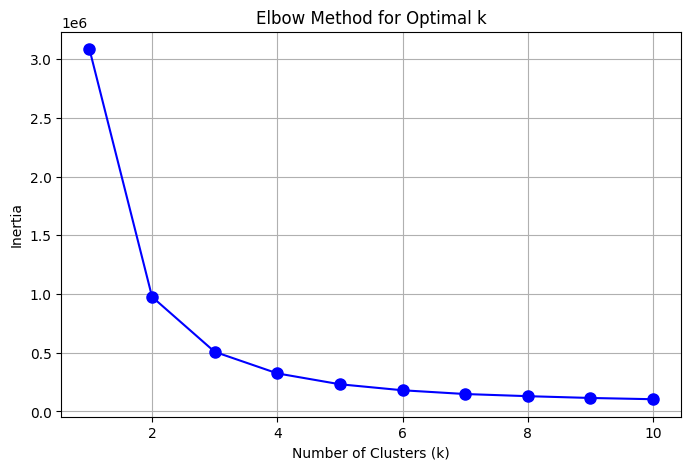

In [36]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Zakres liczby klastrów do przetestowania
k_values = range(1, 11)
inertia = []

# Obliczanie inercji dla różnych liczby klastrów
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_cpu)  # features_cpu to dane z encodera
    inertia.append(kmeans.inertia_)

# Wizualizacja metody łokcia
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()

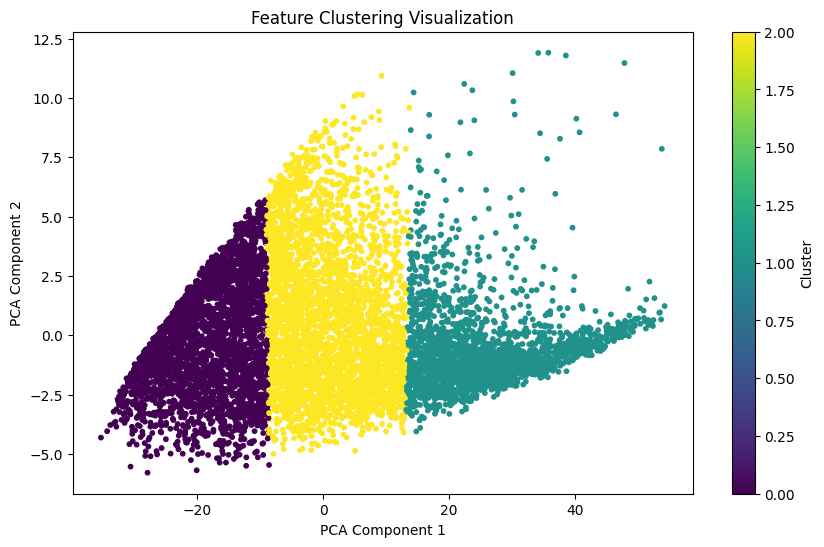

In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Liczba klastrów
clusters = 3

# Klasteryzacja
kmeans = KMeans(n_clusters=clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_cpu)

# Redukcja wymiarów z PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_cpu)

# Wizualizacja klastrów
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.colorbar(label='Cluster')
plt.title('Feature Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()